# Support Class 4 - Problem sheet 3

In [1]:
# Load some packages 
# (if you get an error, you need to install the package in the terminal)
import numpy as np                #scientific computing
from scipy.stats import multivariate_normal   #for probability distributions
from scipy.stats import norm                   #for probability distributions
import scipy.linalg               #for e'values/vectors
import matplotlib.pyplot as plt   #plotting
import seaborn as sns             #helps with data manipulation/plotting
import math                       #calculating exponentials below

#### Question 2

Consider the CTMC from Problem 2 in Assignment 1, i.e. $(X(t):t \geq 0)$ with generator matrix:

In [2]:
G = np.array([[-2,1,1],[1,-4,3],[0,1,-1]])
print(G)

[[-2  1  1]
 [ 1 -4  3]
 [ 0  1 -1]]


Suppose the state space of this chain is $S=\{1,2,3\}$. We will use the algorithm from the lectures to generate paths of this CTMC.

First calculate the transition probalities:

$$p^Y(x,y) = (1 - \delta_{x,y}) \frac{g(x,y)}{|g(x,x)|} .$$

In [3]:
diag_G = np.abs(np.diag(G))
P = np.eye(3,3) + G / diag_G[:,None]    # G / diag_G[:,None] divides row i by the (i,i) element
print(P)

[[0.   0.5  0.5 ]
 [0.25 0.   0.75]
 [0.   1.   0.  ]]


Simulate the CTMC by adapting the code from last week:

In [4]:
#This function for simulates a CTMC. It takes inputs:
# G: generator matrix (3 x 3)
# tmax: final run time (Starting at t = 0)
# IC: initial starting position the chain

def ThreeStateCTMC(G, tmax, IC):
    Y = np.array([IC])      #initialise the MC (state vector)
    J = np.array([0])       #initialise time at t = 0 (jump times vector)

    #calculate the transition matrix
    diag_G = np.abs(np.diag(G))
    P = np.eye(3,3) + G / diag_G[:,None]

    #simulate the chain up until end time
    t = 0
    while t < tmax:
        current_state = Y[-1]
        
        #randomly sample the holding time from the exponential distribution (givent the current state)
        holding_time = np.random.exponential(np.abs(G[current_state-1,current_state-1]))        
        
        #add holding time to the current time
        t = t + holding_time
        
        #store jump times
        J = np.append(J,t)

        #randomly jump to another state using the transistion matrix
        Y = np.append(Y,np.random.choice([1,2,3],1,replace=True,p = P[current_state-1,:]))
        


    return J, Y

Now that we have the function, let's simulate a chain.

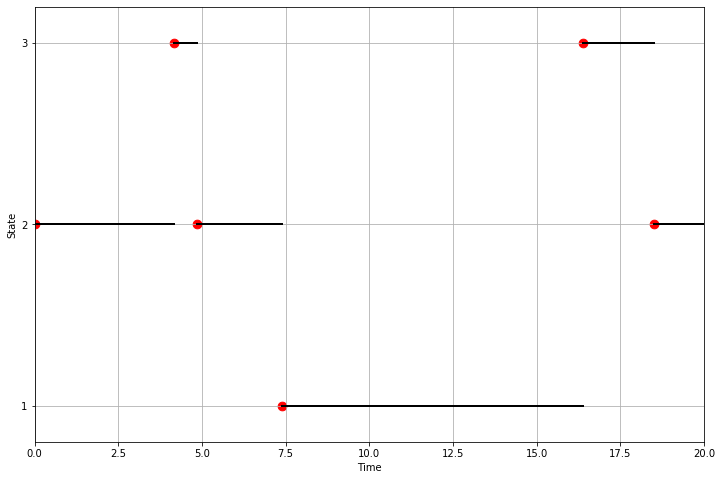

In [5]:
#inputs
G = np.array([[-2,1,1],[1,-4,3],[0,1,-1]])
tmax = 20
IC = 2

#run function
J,Y = ThreeStateCTMC(G, tmax, IC)

#plot the jumps 

#matplotlib inline
plt.figure(figsize = (12,8))
plt.grid()
plt.xlabel('Time')
plt.ylabel('State')
plt.xlim([0,tmax])
plt.ylim([0.8,3.2])
plt.yticks([1,2,3])
for j in range(0,len(J)-1):
    plt.plot([J[j],J[j+1]], [Y[j],Y[j]],'k',lw=2)
plt.scatter(J, Y,s=75,color='r')


#### Question 3(a)

Draw 1000 samples from a 2D multivariate (bivariate) Gaussian distribution.

Rather than plotting the 2D histogram, I just display the samples in the 2D plane and overlay the theoretical PDF (in the form of contour lines).

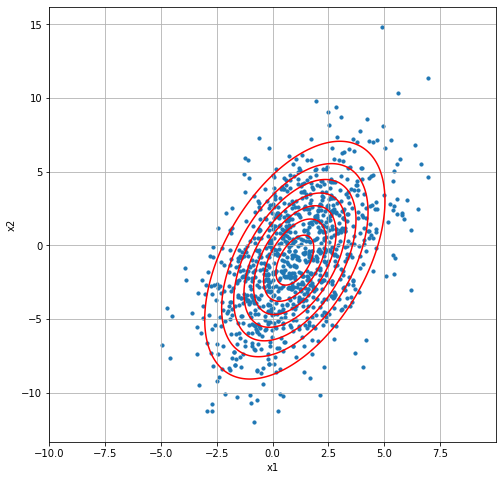

In [6]:
#define parameters
mu1 = 1
mu2 = -1
mu = np.array([mu1,mu2])

sig11 = 2
sig22 = 4
rho12 = 0.5  #must be in [0,1]
sigma = np.array([[sig11**2,rho12*sig11*sig22],[rho12*sig11*sig22,sig22**2]])

samples = np.random.multivariate_normal(mu,sigma,1000)

plt.figure(figsize = (8,8))
plt.grid()
#plt.hist2d(samples[:,0],samples[:,1],bins=50,density=False)
plt.scatter(samples[:,0],samples[:,1],s=10)
plt.xlabel("x1")
plt.ylabel("x2")

X1,X2 = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.dstack((X1,X2))
rv = multivariate_normal(mu,sigma)
plt.contour(X1,X2,rv.pdf(pos),colors='r')
plt.show()


Next we can observe the marginal distributions of $X_1$ and $X_2$ respectively - also we can overlay the theoretical marginal distributions. 

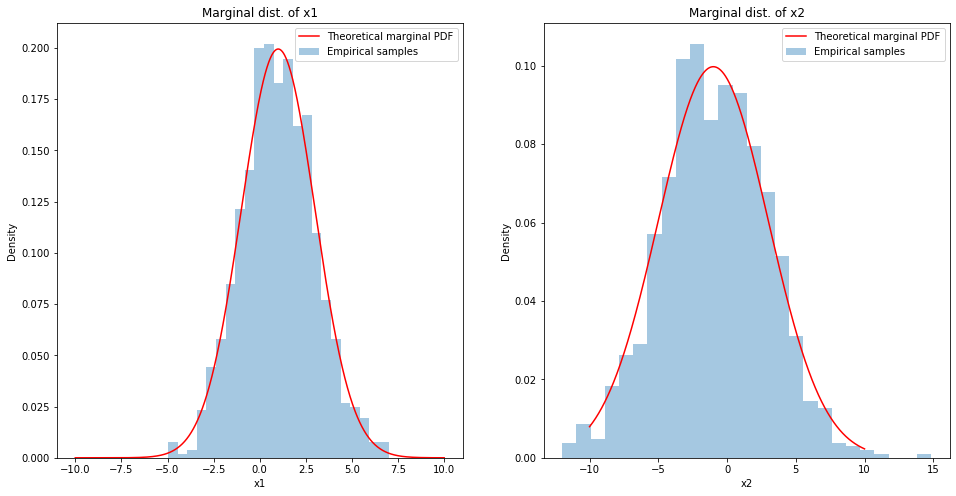

In [7]:
# for theoretical pdfs
x1 = np.linspace(-10,10, 1000)
x2 = np.linspace(-10,10, 1000)



plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
sns.distplot(samples[:,0],kde=False,norm_hist=True,label='Empirical samples')
plt.plot(x1,norm.pdf(x1,mu1,sig11),'r', label='Theoretical marginal PDF')
plt.title('Marginal dist. of x1')
plt.xlabel("x1")
plt.ylabel("Density")
plt.legend()

plt.subplot(1,2,2)
sns.distplot(samples[:,1],kde=False,norm_hist=True,label='Empirical samples')
plt.plot(x2,norm.pdf(x2,mu2,sig22),'r', label='Theoretical marginal PDF')
plt.title('Marginal dist. of x2')
plt.xlabel("x2")
plt.ylabel("Density")
plt.legend()
